In [10]:
from scipy.special import softmax
import torch
import pandas as pd
import numpy as np
import math

In [11]:
math.log(10000.0) 

9.210340371976184

In [2]:
softmax([14, 12])

array([0.88079708, 0.11920292])

In [4]:
data_dict = {
    'ETTh1':"Dataset_ETT_hour",
    'ETTh2':"Dataset_ETT_hour",
    'ETTm1':"Dataset_ETT_minute",
    'ETTm2':"Dataset_ETT_minute",
    'WTH':"Dataset_Custom",
    'ECL':"Dataset_Custom",
    'Solar':"Dataset_Custom",
    'custom':"Dataset_Custom",
}

In [20]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080'

In [18]:
torch.cuda.get_device_capability(0)

(6, 1)

In [19]:
!nvidia-smi

Mon Jan  9 14:43:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:1C:00.0  On |                  N/A |
|  0%   46C    P8    17W / 240W |   2067MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [50]:
df = pd.read_pickle('data/ETT/capacity_price_processed.pkl')
df['date'] = df['date'].apply(lambda cell: cell.strftime("%Y-%m-%d %H:%M:%S"))

product_types = df['product'].unique()

save_path = 'data/ETT/'

for prod in product_types:
    df_ = df[df['product'] == prod][['date', 'capacity_price']]
    save_name = f'SRL_{prod}.csv'
    df_.to_csv(f'{save_path}{save_name}', index=False)

In [11]:
df_ = df[df['product'] == 'NEG_00_04']

In [41]:
df_ = pd.read_csv('data/ETT/SRL_NEG_00_04.csv')

In [38]:
df['date'] = df['date'].apply(lambda cell: cell.strftime("%Y-%m-%d %H:%M:%S"))

In [35]:
d = df['date'].strftime("%Y-%m-%d %H:%M:%S")

AttributeError: 'Series' object has no attribute 'strftime'

In [33]:
d.strftime("%Y-%m-%d %H:%M:%S")

'2020-11-01 00:00:00'

### Test: `utils.timefeatures.time_features()`

In [52]:
from typing import List

import numpy as np
import pandas as pd
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset

def time_features(dates, timeenc=1, freq='h'):
    """
    > `time_features` takes in a `dates` dataframe with a 'dates' column and extracts the date down to `freq` where freq can be any of the following if `timeenc` is 0: 
    > * m - [month]
    > * w - [month]
    > * d - [month, day, weekday]
    > * b - [month, day, weekday]
    > * h - [month, day, weekday, hour]
    > * t - [month, day, weekday, hour, *minute]
    > 
    > If `timeenc` is 1, a similar, but different list of `freq` values are supported (all encoded between [-0.5 and 0.5]): 
    > * Q - [month]
    > * M - [month]
    > * W - [Day of month, week of year]
    > * D - [Day of week, day of month, day of year]
    > * B - [Day of week, day of month, day of year]
    > * H - [Hour of day, day of week, day of month, day of year]
    > * T - [Minute of hour*, hour of day, day of week, day of month, day of year]
    > * S - [Second of minute, minute of hour, hour of day, day of week, day of month, day of year]

    *minute returns a number from 0-3 corresponding to the 15 minute period it falls into.
    """
    if timeenc==0:
        dates['month'] = dates.date.apply(lambda row:row.month,1)
        dates['day'] = dates.date.apply(lambda row:row.day,1)
        dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
        dates['hour'] = dates.date.apply(lambda row:row.hour,1)
        dates['minute'] = dates.date.apply(lambda row:row.minute,1)
        dates['minute'] = dates.minute.map(lambda x:x//15)
        freq_map = {
            'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
            'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
            't':['month','day','weekday','hour','minute'],
        }
        return dates[freq_map[freq.lower()]].values
    if timeenc==1:
        dates = pd.to_datetime(dates.date.values)
        return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)]).transpose(1,0)

In [53]:
df = pd.read_csv('data/ETT/SRL_NEG_00_04.csv')

In [69]:
dates

,date
0,2020-11-01 00:00:00
1,2020-11-02 00:00:00
2,2020-11-03 00:00:00
3,2020-11-04 00:00:00
4,2020-11-05 00:00:00
...,...
780,2022-12-21 00:00:00
781,2022-12-22 00:00:00
782,2022-12-23 00:00:00
783,2022-12-24 00:00:00


In [75]:
df_stamp = df[['date']]
df_stamp['date'] = pd.to_datetime(df_stamp.date)
stamp = time_features(df_stamp, timeenc=0, freq='d')

C:\Users\93cha\AppData\Local\Temp/ipykernel_17640/2697475164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stamp['date'] = pd.to_datetime(df_stamp.date)


In [81]:
stamp[0:10].shape

(10, 3)

### Test embedding codes

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd

from exp.exp_informer import Exp_Informer
import matplotlib.pyplot as plt

from utils.masking import TriangularCausalMask, ProbMask
from models.encoder import Encoder, EncoderLayer, ConvLayer, EncoderStack
from models.decoder import Decoder, DecoderLayer
from models.attn import FullAttention, ProbAttention, AttentionLayer
from models.embed import DataEmbedding, PositionalEmbedding, TokenEmbedding, FixedEmbedding, TemporalEmbedding, TimeFeatureEmbedding

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

from utils.tools import StandardScaler
from utils.timefeatures import time_features

from data.data_loader import Dataset_ETT_hour, Dataset_ETT_minute, Dataset_Custom, Dataset_Pred
from exp.exp_basic import Exp_Basic
from models.model import Informer, InformerStack

from utils.tools import EarlyStopping, adjust_learning_rate
from utils.metrics import metric

In [17]:
# Create dataset
df_raw = pd.read_csv('data/ETT/SRL_NEG_00_04.csv')

train =  Dataset_Custom('data/ETT/', freq= 'd', data_path='SRL_NEG_00_04.csv', target='capacity_price')
test =  Dataset_Custom('data/ETT/', freq= 'd', data_path='SRL_NEG_00_04.csv', target='capacity_price',flag='test')
vali =  Dataset_Custom('data/ETT/', freq= 'd', data_path='SRL_NEG_00_04.csv', target='capacity_price', flag='val')
# pred =  Dataset_Custom('data/ETT/', freq= 'd', data_path='SRL_NEG_00_04.csv', target='capacity_price', flag='pred')

In [18]:
train_loader = DataLoader(train, batch_size=2)

In [19]:
sample_loader = next(iter(train_loader))
batch_x, batch_y, batch_x_mark, batch_y_mark = sample_loader

# Input sequence length
batch_x.shape[1]

384

In [29]:
c_in=1
d_model=64

In [35]:
positional_emb = PositionalEmbedding(d_model=d_model)
positional_emb_out = positional_emb(batch_x)

value_emb = TokenEmbedding(c_in=c_in, d_model=d_model)
value_emb_out = value_emb(batch_x.float()) # Convert to float for compatibility

timef_emb = TimeFeatureEmbedding(d_model=d_model, freq='d')
timef_emb_out = timef_emb(batch_x_mark.float())

data_emb = DataEmbedding(c_in=c_in, d_model=d_model, embed_type='timeF', freq='d')
data_emb_out = data_emb(batch_x.float(), batch_x_mark.float())

In [36]:
print('Data input dimension:')
print(batch_x.size())
print('Time feature input dimension:')
print(batch_x_mark.size())
print('Positional embedding outputs:')
print(positional_emb_out.size())
print('Value (token) embedding outputs:')
print(value_emb_out.size())
print('Temporal embedding outputs:')
print(timef_emb_out.size())
print('Data embedding outputs:')
print(data_emb_out.size())

Data input dimension:
torch.Size([2, 384, 1])
Time feature input dimension:
torch.Size([2, 384, 3])
Positional embedding outputs:
torch.Size([1, 384, 64])
Value (token) embedding outputs:
torch.Size([2, 384, 64])
Temporal embedding outputs:
torch.Size([2, 384, 64])
Data embedding outputs:
torch.Size([2, 384, 64])


In [128]:
m = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=3)
m.weight

Parameter containing:
tensor([[[-0.0602,  0.2239,  0.2568]],

        [[ 0.3471,  0.2856, -0.2307]],

        [[ 0.0192,  0.3263,  0.2953]],

        [[-0.3622,  0.3187,  0.4643]]], requires_grad=True)

In [114]:
df_raw = pd.read_csv('data/ETT/ETTh1-mini.csv')

df_stamp = df_raw[['date']]
df_stamp['date'] = pd.to_datetime(df_stamp.date)
data_stamp = time_features(df_stamp, timeenc=0, freq='d')

In [115]:
df_scale = df_raw.iloc[:,1:]
scaler = StandardScaler()
scaler.fit(df_scale.values)

In [116]:
res = scaler.transform(df_scale.values)

In [126]:
[a for a in range(1,3)]

[1, 2]

In [128]:
class TestConv(nn.Module):
    def __init__(self, c_in, c_out):
        super(TestConv, self).__init__()
        self.c_in = c_in
        self.c_out = c_out
        self.conv = nn.Conv1d(in_channels=c_in, out_channels=c_out, kernel_size=3, padding=1,
                              padding_mode='circular')
        
    def forward(self, x):
        x = self.conv(x)
        return x

### Plot prediction & true

In [39]:
pred_seq_raw = np.load('results/informer_SRL_NEG_00_04_ftM_sl96_ll48_pl3_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_5/pred.npy')
true_seq_raw = np.load('results/informer_SRL_NEG_00_04_ftM_sl96_ll48_pl3_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_5/true.npy')

In [65]:
import matplotlib.pyplot as plt

class Result():
    def __init__(self, data_path, pred_seq_raw, true_seq_raw, root_path='data/ETT'):
        train = Dataset_Custom('data/ETT/', freq= 'd', data_path=data_path, target='capacity_price')
        self.scaler = train.scaler
        self.pred_len = pred_seq_raw.shape[0]
        self.pred_raw = self.convert_seq(pred_seq_raw, inverse=False)
        self.true_raw = self.convert_seq(true_seq_raw, inverse=False)
        self.pred = self.convert_seq(pred_seq_raw, inverse=True)
        self.true = self.convert_seq(true_seq_raw, inverse=True)
        self.pred_naive = self.true.shift(1)
    
    def convert_seq(self, seq_raw, inverse=True):
        if inverse: 
            seq = train.scaler.inverse_transform(seq_raw)
        else: seq = seq_raw
        array = seq.squeeze()
        array = np.array([np.concatenate([np.repeat(np.nan, i), array[i], np.repeat(np.nan, self.pred_len-i)]) for i in np.arange(self.pred_len)])
        df = pd.DataFrame(array.transpose())
        return df.mean(axis=1)

    def plot_pred_vs_true(self, pred, true):
        fig = plt.figure(figsize=(12,6))
        plt.plot(true, label='True')
        plt.plot(pred, label ='Predict')
        plt.legend()
        # for idx in df_rev.index:
        #     plt.vlines(idx, df_rev.loc[idx]['revenue'],0, label ='Revenue', linestyle='--') 
        plt.close()
        return(fig)
    
    def predict_revenue(self, pred):
        return np.nansum(np.where(pred > self.true, 0, pred))

In [57]:
result.pred_naive

0           NaN
1     24.689918
2     20.936015
3     20.775790
4     23.429636
        ...    
62    41.023480
63    39.423550
64    27.506824
65    38.509668
66    29.793849
Length: 67, dtype: float64

In [66]:
result = Result(data_path='SRL_NEG_00_04.csv', pred_seq_raw=pred_seq_raw, true_seq_raw=true_seq_raw)

In [73]:
result.predict_revenue(result.pred)

1131.1616505880759

In [68]:
result.predict_revenue(result.pred_naive)

739.0070552141583

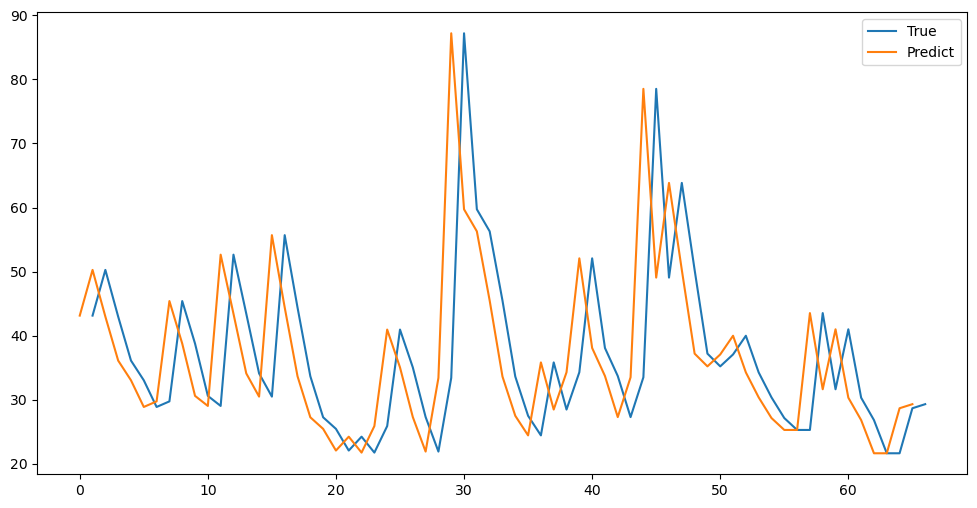

In [69]:
result.plot_pred_vs_true(pred=result.true, true=result.pred_naive)

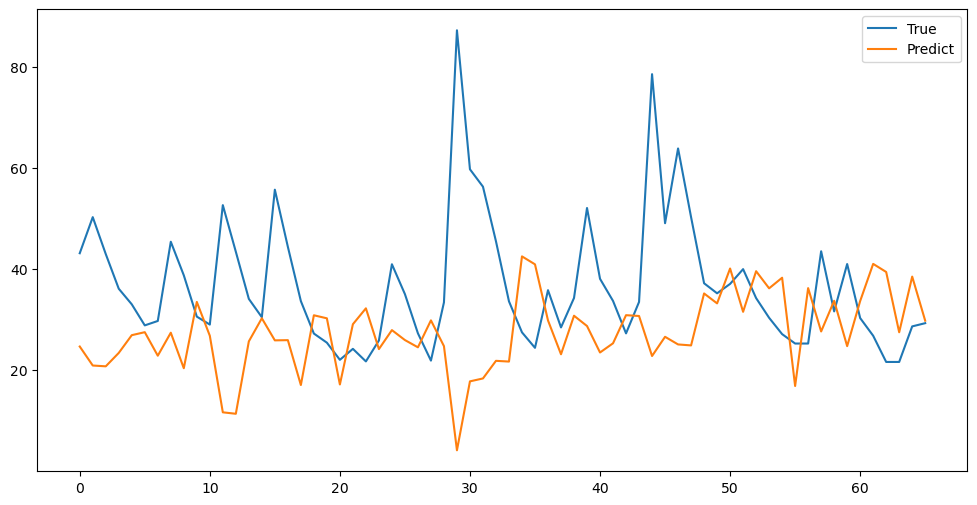

In [70]:
result.plot_pred_vs_true(pred=result.pred, true=result.true)

Preedicted revenue: 1131.1616505880759


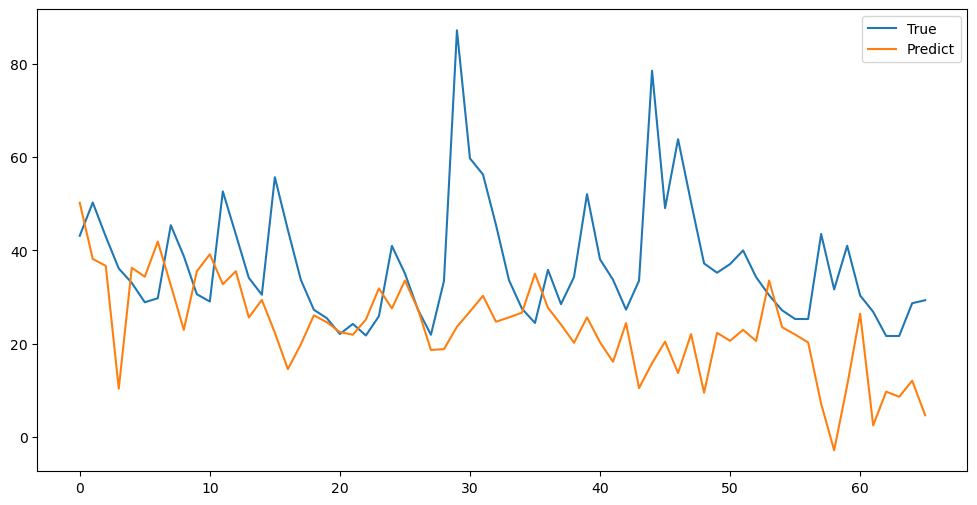

In [72]:
pred_seq_raw = np.load('results/informer_SRL_NEG_00_04_alpha10.0_ftM_sl96_ll48_pl3_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_5_25-01-2023_23-53-39/pred.npy')
true_seq_raw = np.load('results/informer_SRL_NEG_00_04_alpha10.0_ftM_sl96_ll48_pl3_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_5_25-01-2023_23-53-39/true.npy')

result = Result(data_path='SRL_NEG_00_04.csv', pred_seq_raw=pred_seq_raw, true_seq_raw=true_seq_raw)

print(f'Preedicted revenue: {result.predict_revenue(result.pred)}')

result.plot_pred_vs_true(pred=result.pred, true=result.true)


In [70]:
# Create dataset
df_raw = pd.read_csv('data/ETT/SRL_NEG_00_04.csv')

train =  Dataset_Custom('data/ETT/', freq= 'd', data_path='SRL_NEG_00_04.csv', target='capacity_price')
test =  Dataset_Custom('data/ETT/', freq= 'd', data_path='SRL_NEG_00_04.csv', target='capacity_price',flag='test')
vali =  Dataset_Custom('data/ETT/', freq= 'd', data_path='SRL_NEG_00_04.csv', target='capacity_price', flag='val')

In [71]:
pred_seq = train.scaler.inverse_transform(pred_seq_raw)
true_seq = train.scaler.inverse_transform(true_seq_raw)

In [72]:
true_array = true_seq.squeeze()
pred_len = true_array.shape[0] 
true_array = np.array([np.concatenate([np.repeat(np.nan, i), true_array[i], np.repeat(np.nan, pred_len-i)]) for i in np.arange(pred_len)])

pred_array = pred_seq.squeeze()
pred_array = np.array([np.concatenate([np.repeat(np.nan, i), pred_array[i], np.repeat(np.nan, pred_len-i)]) for i in np.arange(pred_len)])

In [73]:
true_df = pd.DataFrame(true_array.transpose())
true = true_df.mean(axis=1)
pred_df = pd.DataFrame(pred_array.transpose())
pred = pred_df.mean(axis=1)

In [74]:
pred

0      114.921017
1      110.013496
2      106.107333
3       96.984185
4      103.433627
          ...    
147    343.495122
148    358.020845
149    329.128450
150    334.403134
151           NaN
Length: 152, dtype: float64

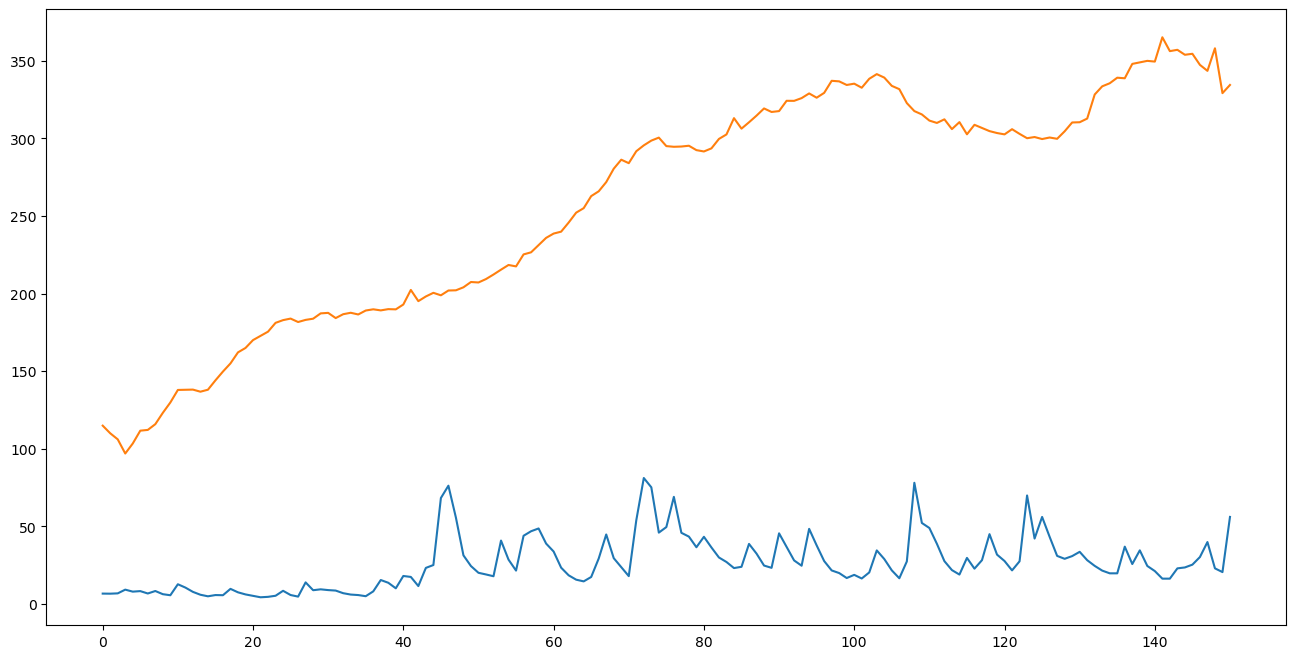

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(true, label='True')
plt.plot(pred, label='Pred')

### Test custom loss function

In [75]:
true = torch.randn(3, 2, 1)
pred = torch.randn(3, 2, 1)
alpha = 5

In [82]:
diff = pred - true

In [83]:
weighted_diff = torch.where(diff > 0, diff*alpha, diff)

In [87]:
print((weighted_diff**2).mean())

tensor(36.0665)


In [89]:
weighted_diff.mean()

tensor(3.2834)

In [7]:
class WeightedRMSE(nn.Module):
    def __init__(self, alpha):
        super(WeightedRMSE, self).__init__()
        self.alpha = alpha
    
    def forward(self, pred, true):
        diff = pred - true
        weighted_diff = torch.where(diff > 0, diff*self.alpha, diff)
        print(weighted_diff)
        return torch.sqrt((weighted_diff**2).mean())

In [4]:
a = torch.Tensor([1, 2, 3])
b = torch.Tensor([2, 1, 3])

In [8]:
loss = WeightedRMSE(alpha=5)
loss(a, b)

tensor([-1.,  5.,  0.])


tensor(2.9439)

In [103]:
loss = nn.MSELoss()
loss(pred, true)

tensor(3.0354)

In [ ]:
def RevenueLoss(pred, true):
    return torch.where(pred > true, 0, pred).sum()*(-1)

In [53]:
class RevenueLoss(nn.Module):
    def __init__(self):
        super(RevenueLoss, self).__init__()
    
    def forward(self, pred, true):
        return torch.where(pred > true, 0, pred).sum()*(-1)

In [54]:
criterion = RevenueLoss()
criterion(pred, true)

tensor(-0.6804)

In [51]:
torch.where(pred > true, 0, pred).sum()*(-1)

tensor(-0.6804)

In [8]:
diff = true - pred

In [18]:
torch.concat((diff, torch.zeros(10)), dim=)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [13]:
torch.zeros(10)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
torch.maximum(diff, torch.zeros(10))

tensor([0.9606, 0.3384, 0.0000, 0.0000, 0.3742, 0.2523, 0.2486, 0.0648, 0.1623,
        0.2631])

In [66]:
from datetime import datetime
now = datetime.now().strftime("%d-%m-%Y_%H:%M:%S")

In [64]:
datetime.now().strftime("%d-%m-%Y_%H:%M:%S")

'25-01-2023_16:39:08'

In [67]:
'dw' + now

'dw25-01-2023_16:40:25'